In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from flask import Flask, Response, render_template
import threading
import time

from PIL import Image
import requests  

# Image Face & eye detection 

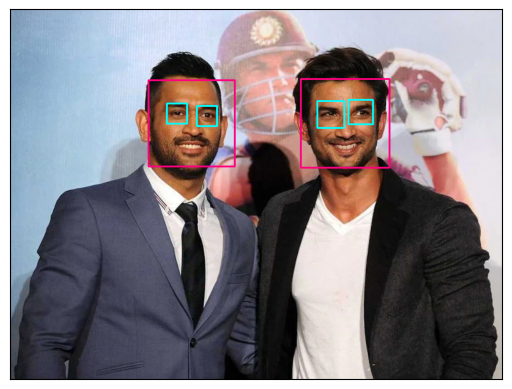

In [35]:
# Load the face and eye Haar cascade classifiers
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")


img = cv2.imread('image.jpg')

# Check if the image is loaded correctly
if img is None:
    print("Error: Image not found or cannot be loaded!")
    exit()  # Exit if image is not loaded

# Convert image to grayscale for face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

# Check if faces are detected
if len(faces) == 0:
    print("No Face Found")

# Draw rectangles around detected faces and detect eyes within each face
for (x, y, w, h) in faces:
    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (127, 0, 255), 2)
    
    # Region of interest (ROI) for face
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]

    # Detect eyes within the face region
    eyes = eye_classifier.detectMultiScale(roi_gray)

    for (ex, ey, ew, eh) in eyes:
        # Draw rectangle around each detected eye
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (255, 255, 0), 2)

# Display the output image with rectangles around faces and eyes
cv2.imshow('img', img)

# Wait for a key press before closing the window
cv2.waitKey(0)

# Destroy all OpenCV windows
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

# Live (System Camera)Face & eye detection

In [33]:
# app.py
import cv2


app = Flask(__name__)

# Load cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade  = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
if face_cascade.empty() or eye_cascade.empty():
    raise RuntimeError("Failed to load Haar cascades. Check your OpenCV installation.")

# Open default camera (0). Change to path or index if needed.
video_src = 0
cap = cv2.VideoCapture(video_src)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video source {video_src}")

lock = threading.Lock()

def gen_frames():
    """Generator that yields MJPEG frames with annotated detections."""
    while True:
        with lock:
            success, frame = cap.read()
        if not success:
            break

        # Convert to gray and detect
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Draw rectangle around face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Search for eyes in upper half of face ROI to reduce false positives
            roi_gray = gray[y:y + h//2, x:x + w]
            roi_color = frame[y:y + h//2, x:x + w]
            eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=6, minSize=(10, 10))

            for (ex, ey, ew, eh) in eyes:
                center = (x + ex + ew//2, y + ey + eh//2)
                radius = int(round((ew + eh) / 4.0))
                cv2.circle(frame, center, radius, (255, 0, 0), 2)

        # Encode frame as JPEG
        ret, buffer = cv2.imencode('.jpg', frame)
        if not ret:
            continue

        frame_bytes = buffer.tobytes()
        # multipart response chunk
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame_bytes + b'\r\n')

@app.route('/')
def index():
    # Simple page with <img> showing /video_feed
    return render_template('index.html')

@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

if __name__ == '__main__':
    # Use 0.0.0.0 to allow other devices on network to connect (optional)
    app.run(host='0.0.0.0', port=5000, debug=False, threaded=True)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.103:5000
Press CTRL+C to quit
192.168.1.103 - - [14/Nov/2025 08:48:27] "GET / HTTP/1.1" 200 -
192.168.1.103 - - [14/Nov/2025 08:48:27] "GET /video_feed HTTP/1.1" 200 -
